In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

2024-05-22 06:25:43.823932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 06:25:43.824080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 06:25:44.041324: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

In [3]:
data.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [8]:
#normalized pixel values
pixel_vars = [var for var in data.columns if var.startswith("pixel")]
for var in pixel_vars:
    data[var] /= 255

In [9]:
features = data.iloc[:, 1:].values  # Excludes the label if it's the first column
labels = data.iloc[:,0].values

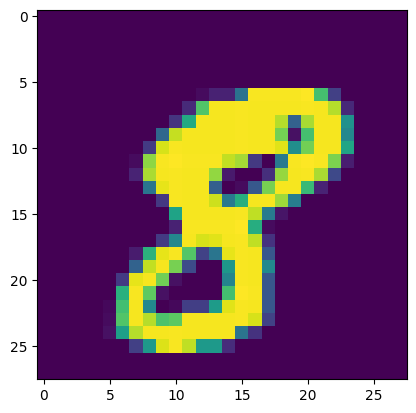

In [10]:
features_reshaped = features.reshape(-1,28,28,1)

#plot one dataset
plt.imshow(features_reshaped[10,:,:])

In [11]:
#convert dataset to tensor
features_tensor = tf.convert_to_tensor(features_reshaped, dtype=tf.float32)
labels_tensor = tf.convert_to_tensor(labels, dtype=tf.int32)


In [34]:
# Assuming features_tensor and labels_tensor are your datasets
N_exp = features_tensor.shape[0]
indices = tf.range(start=0, limit=N_exp, dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

features_tensor = tf.gather(features_tensor, shuffled_indices)
labels_tensor = tf.gather(labels_tensor, shuffled_indices)

# Calculate the number of training examples
train_size = int(0.8 * N_exp)

# Split the features and labels into training and validation sets
X_train = features_tensor[:train_size]
y_train = labels_tensor[:train_size]
X_valid = features_tensor[train_size:]
y_valid = labels_tensor[train_size:]

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
augmented_data_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Training data without augmentation for comparison (only in debug mode set Shuffle to False for comparison in next cell)
train_data_gen = ImageDataGenerator()

# Validation data generator without augmentation
validation_datagen = ImageDataGenerator()  # No augmentation for validation data

# Configure generators to load data
train_generator = train_data_gen.flow(X_train, y_train, batch_size=32,shuffle=True)
augmented_data_gen = augmented_data_gen.flow(X_train, y_train, batch_size=32,shuffle=True)
validation_generator = validation_datagen.flow(X_valid, y_valid, batch_size=32)


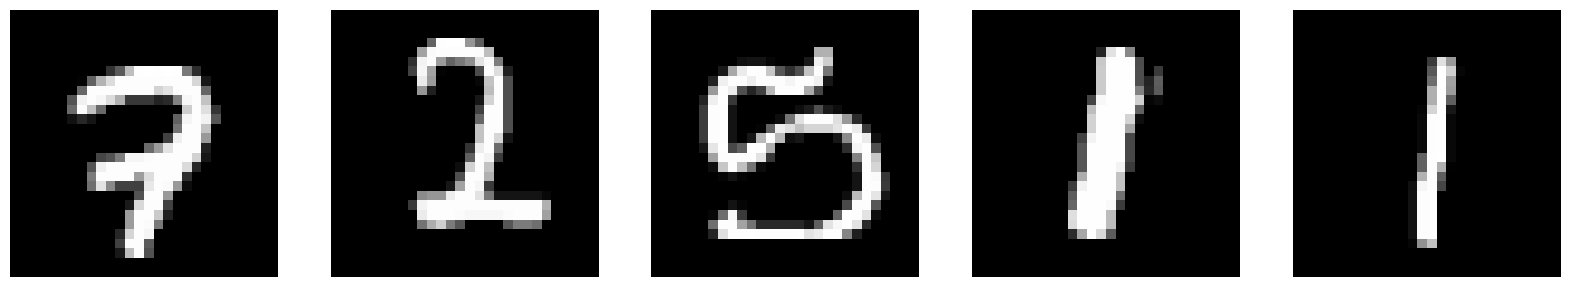

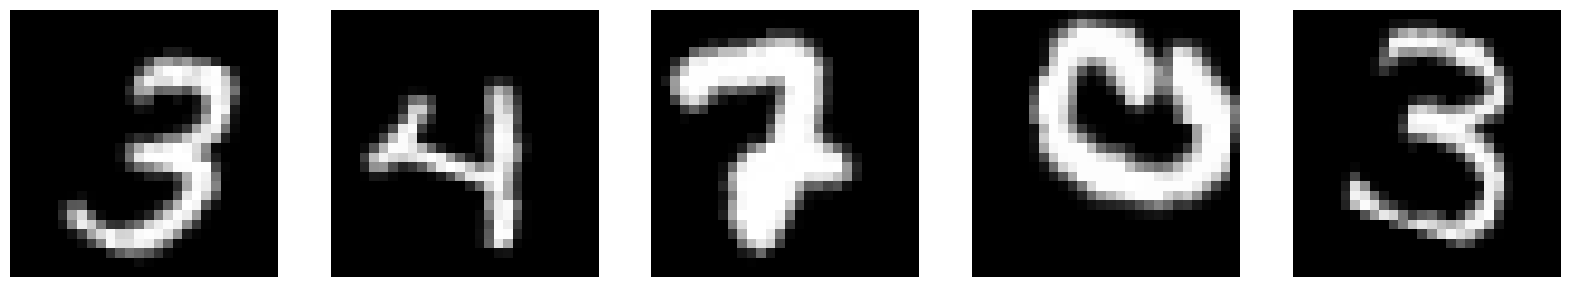

In [38]:
# Get a batch of images
x_batch, y_batch = next(train_generator)
x_batch2, y_batch2 = next(augmented_data_gen)

# Function to plot images in a grid
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.squeeze(), cmap='gray')  # Assuming grayscale images; remove 'cmap' for RGB
        ax.axis('off')
    plt.show()

# Plot the images
plot_images(x_batch[:5])  # Plot the first 5 images from the batch
plot_images(x_batch2[:5])  # Plot the first 5 images from the batch


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

# Create a Sequential model
model = Sequential([
    # Convolutional layer: 32 filters, kernel size of 3x3
    Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28, 1)),
    BatchNormalization(),
    Activation('relu'),
    # MaxPooling layer: Pooling size of 2x2
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(16, kernel_size=(3, 3)),
    BatchNormalization(),
    Activation('relu'),

    # Flatten layer to flatten the output of the previous layers into a single vector
    Flatten(),
    # Dense layer with increased capacity
    Dense(128, activation='relu'),
    BatchNormalization(),
    # Dropout layer to reduce overfitting
    Dropout(0.5),
    # Output layer with 10 units (for 10 classes of digits 0-9) and softmax activation
    Dense(10, activation='softmax')
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [65]:
# Model setup as previously defined
history = model.fit(
    augmented_data_gen,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch=len(X_train) // 32,
    validation_steps=len(X_valid) // 32)

Epoch 1/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 44s 38ms/step - accuracy: 0.8718 - loss: 0.4329 - val_accuracy: 0.9792 - val_loss: 0.0658
Epoch 2/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - accuracy: 0.9678 - loss: 0.1013 - val_accuracy: 0.9804 - val_loss: 0.0625
Epoch 3/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9771 - loss: 0.0776 - val_accuracy: 0.9793 - val_loss: 0.0650
Epoch 4/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9797 - loss: 0.0699 - val_accuracy: 0.9639 - val_loss: 0.1210
Epoch 5/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.9778 - loss: 0.0700 - val_accuracy: 0.9874 - val_loss: 0.0394
Epoch 6/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9830 - loss: 0.0556 - val_accuracy: 0.9874 - val_loss: 0.0424
Epoch 7/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9827 - loss: 0.0518 - val_accuracy: 0.9907 - val_loss: 0.0296
Epoch 8/10
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9847 -

KeyboardInterrupt: 

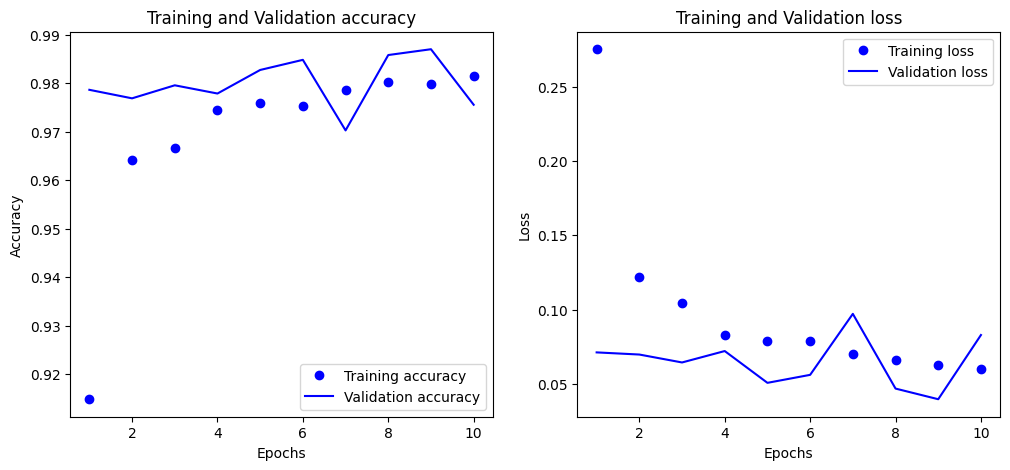

In [66]:
import matplotlib.pyplot as plt

# Accessing the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [37]:
data_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
data_test.head()


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
features_test = data_test.iloc[:,:].values
features_test = features_test/255
features_test = features_test.reshape(-1,28,28)
features_test.shape

(28000, 28, 28)

In [39]:
predictions = model.predict(features_test)

875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


In [40]:
predictions = np.argmax(predictions, axis=1)

In [41]:
predictions

array([2, 0, 9, ..., 3, 9, 2])

In [42]:
submission = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)